In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [23]:
loss_values = []
ics_values = []
cos = torch.nn.CosineSimilarity(dim=0)

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        if i >= 10:
            break
#         get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#         print(inputs.size())
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
#         # ICS calc
        dummyNet = Net()
        netParams = list(net.parameters())
        for idx, p in enumerate(dummyNet.parameters()):
            p.data = netParams[idx].data.clone()
            p.grad = netParams[idx].grad.data.clone()
        #print(list(dummyNet.parameters())[1])
        #print(list(net.parameters())[1])
        #print(list(dummyNet.parameters())[1].grad)
        #print(list(net.parameters())[1].grad)
        learning_rate = 0.1
        layerParam = 0
        for f in dummyNet.parameters(): # si aggiornano i parametri fino al layer i
            if(layerParam//2 < 1):
                f.data.sub_(f.grad.data * learning_rate)
                layerParam += 1
                
        dummyOutputs = dummyNet(inputs) 
        # si calcola la loss con i parametri fino al layer i aggiornati
        dummyLoss = criterion(dummyOutputs, labels) 
        dummyLoss.backward() # nuovi gradienti

        optimizer.step() # si aggiornano i parametri del net di partenza

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print("ICS :" + str((net.conv1.weight.grad - dummyNet.conv1.weight.grad).norm(2)))
            w = torch.flatten(net.conv1.weight.grad)
            print(w.size())
            dw = torch.flatten(dummyNet.conv1.weight.grad)
            print(dw.size())
            print("Cos agle: " + str(cos(w, dw)))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, (i + 1) * 4, running_loss / 10))
            loss_values.append(running_loss/100)
            running_loss = 0.0

print('Finished Training')

ICS :tensor(0.0557)
torch.Size([450])
torch.Size([450])
Cos agle: tensor(0.9961)
[1,    40] loss: 2.293
Finished Training


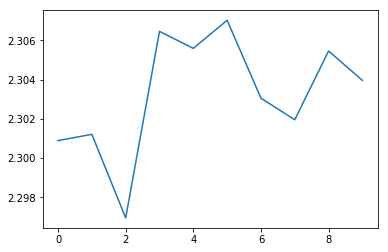

In [13]:
import matplotlib.pyplot as plt

plt.plot(loss_values)